In [1]:
# calculate kiwifruit 's each parts' mua, mus, with equal scale enlarge
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
from cycler import cycler
# import tensorflow as tf
import math
# from scipy.optimize import fsolve
# from scipy.optimize import root
import scipy as scipy
from scipy.optimize import minimize
# from scipy import signal
# from scipy import linalg
# import scipy as scp
# import sympy as  syp
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.models import Sequential
import os
import gc

In [2]:
class process_hyperspec(object):
    
    def __init__(self, path, scat):
        self.path = path
        self.scat = scat
        
    def read_data(self):
        ## Read data from txt
        data=pd.read_fwf(self.path, dtype = object, header = None)## Read data as Pandas DataFrame
        data_8 = data.loc[8,:].str[6:] ## Select data of column of wavelengths

        data_nm_dataframe =pd.read_csv(StringIO(data_8[0]))

        with open(self.path,'r',encoding='utf-8') as f:
            content = f.read()

        flag = 0
        for index in range(len(content)):##find the start point  of time and intensity data, pointer is the 'index'
            if (content[index] == '\n') and (flag != 9):
                flag = flag + 1
            elif (content[index] == '\n') and (flag == 9):
                break
            else:
                continue

        data_ns = pd.read_csv(StringIO(content[index:len(content)]), names = data_nm_dataframe.columns[0:len(set(data_nm_dataframe))]) ## Read data of time and gray 
        img_nm_ns = np.array(data_ns)    ## Transform to numpy array                                image as DataFrame; names is a 640x0 array indicates the wavelengths range
        
        self.data_frame = data_ns
        self.data_array = img_nm_ns
        
    def cal_846nm(self):
        time_total, wavelength_total = self.data_array.shape ## Generate an array contains intensity versus time data on 846nm
        data_846nm = np.zeros((time_total,), dtype = float )

        for i in range(wavelength_total):
            data_846nm = self.data_array[:,i] + data_846nm

        return data_846nm/wavelength_total
    
    def return_dataframe(self):
        
        return self.data_frame
    
    def return_array(self):
        return self.data_array
        

In [4]:
dict0 = {}
for i in range(1,4):
    dict0[i] = '.\\20230303 one kiwi\\20230303\\Sample'+str(i)+'.txt'
dict0[0] = '.\\20230303 one kiwi\\irf00.txt'

dict1 = {}
for i in range(1,4):
    dict1[i] = '.\\20230303 one kiwi\\20230304\\Sample'+str(i)+'.txt'
dict1[0] = '.\\20230303 one kiwi\\irf00.txt'

dict2 = {}
for i in range(1,4):
    dict2[i] = '.\\20230303 one kiwi\\20230305\\Sample'+str(i)+'.txt'
dict2[0] = '.\\20230303 one kiwi\\irf00.txt'

dict3 = {}
for i in range(1,4):
    dict3[i] = '.\\20230303 one kiwi\\20230306\\Sample'+str(i)+'.txt'
dict3[0] = '.\\20230303 one kiwi\\irf00.txt'

dict4 = {}
for i in range(1,4):
    dict4[i] = '.\\20230303 one kiwi\\20230307\\Sample'+str(i)+'.txt'
dict4[0] = '.\\20230303 one kiwi\\irf00.txt'

dict5 = {}
for i in range(1,4):
    dict5[i] = '.\\20230303 one kiwi\\20230308\\Sample'+str(i)+'.txt'
dict5[0] = '.\\20230303 one kiwi\\irf00.txt'

dictn = [dict0,dict1,dict2,dict3,dict4,dict5]

In [5]:
class analyze(object):
    def __init__(self):

        return
    def read_radius(self):
        data1 = pd.read_excel('./kiwi_data.xlsx',sheet_name=1,header=None)
        data2 = np.array(data1)
        return data2[:,1]

    def read_everyday(self,dict0):    
        files = os.listdir(dict0[0][0:-10])   # 读入文件夹
        N = len(files)   # 统计文件夹中的文件个数
        M = 4    
        scat = [None]*M
        data_480multi9 = np.zeros((M,480), dtype = float)
        time_index = np.zeros((M,480))
        j=0
        for i in range(0,M):
            if os.path.exists(dict0[i]):
                scat[j] = process_hyperspec(dict0[i], i)
                scat[j].read_data()
                data_480multi9[i,:] = scat[j].cal_846nm()
                time_index[i] = scat[j].return_dataframe().index
            else:
                data_480multi9[i,:] = 0
                time_index[i] = 0
        return data_480multi9,time_index,N,M

    def generate_h_y(self,data_480multi9,N,M):
        kernel0 = np.ones((10,))
        data_smooth = np.zeros((M-1,480))
        for i in range(M-1):
            data_smooth[i] = np.convolve(kernel0,data_480multi9[i+1],'same')/np.sum(kernel0)
        y = np.zeros((data_smooth.shape[0],data_smooth.shape[1]*2-1))
        y[:,0:data_smooth.shape[1]] = data_smooth
        h = np.convolve(kernel0,data_480multi9[0],'same')/np.sum(kernel0)
        return h,y
        

    

In [6]:
ana = analyze()
H = []
Y = []
TIME = []
R = []
AMOUNT_EXP = len(dictn)
for i in range(AMOUNT_EXP):
    radius = ana.read_radius()
    data_480multi9,time_index,N,M = ana.read_everyday(dictn[i])
    h,y = ana.generate_h_y(data_480multi9,N,M)
    H.append(h)
    Y.append(y)
    TIME.append(time_index)
    R.append(radius)

In [7]:
NUM_REMAIN=0
Y_AVG = [None]*len(Y)
TIME_AVG = [None]*len(TIME)
for i in range(AMOUNT_EXP):
    Y_AVG[i] = np.mean(Y[i][NUM_REMAIN:-1,:],axis=0)
    TIME_AVG[i] = np.mean(TIME[i][NUM_REMAIN:-1,:],axis=0)

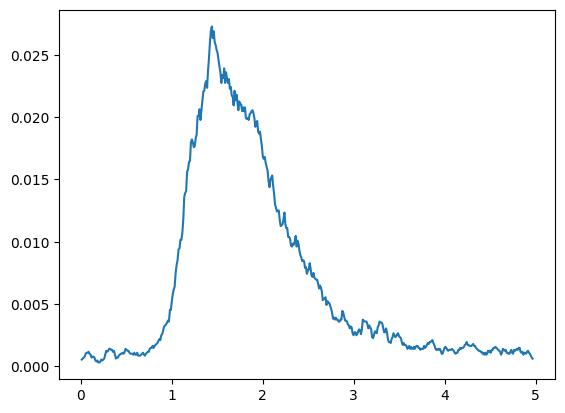

In [8]:
RAN = 2
plt.plot(TIME_AVG[RAN],Y_AVG[RAN][0:480])
plt.show()

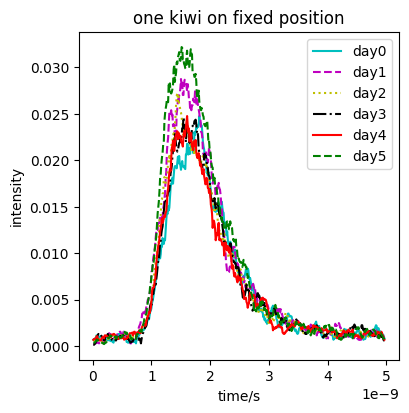

In [10]:
##########################################
fig = plt.figure(figsize = (4,4))
line = []
line_irf = []
for i in range(AMOUNT_EXP):
    # linestyle_cycler = cycler('linestyle',['-','--',':','-.'])
    # plt.rc('axes', prop_cycle=linestyle_cycler)
    plt.rc('axes', prop_cycle=(cycler('color', ['c', 'm', 'y', 'k','r','g','b','brown']) +
                           cycler('linestyle', ['-', '--', ':', '-.','-','--',':','-.'])))
    line0, = plt.plot(TIME_AVG[i]*1e-9, Y_AVG[i][0:data_480multi9.shape[1]])
    # line1, = plt.plot(TIME[i][j+1]*1e-9, H[i]/max(H[i])*0.04,color='black')
    line.append(line0)
    # line_irf.append(line1)
fig.tight_layout(pad=1.1)
line.extend(line_irf)
plt.legend(line,['day0','day1','day2','day3','day4','day5','day6','day7'])
plt.xlabel('time/s')
plt.ylabel('intensity')
plt.title('one kiwi on fixed position')
plt.show()

In [58]:
peak_Y = np.zeros((AMOUNT_EXP,))
peak_position_Y = np.zeros((AMOUNT_EXP,),dtype=float)
for i in range(AMOUNT_EXP):
    pos = np.argmax(Y_AVG[i][0:data_480multi9.shape[1]])
    peak_position_Y[i] = TIME_AVG[i][pos]*1e-9
    peak_Y[i] = Y_AVG[i][pos]

<Figure size 500x600 with 0 Axes>

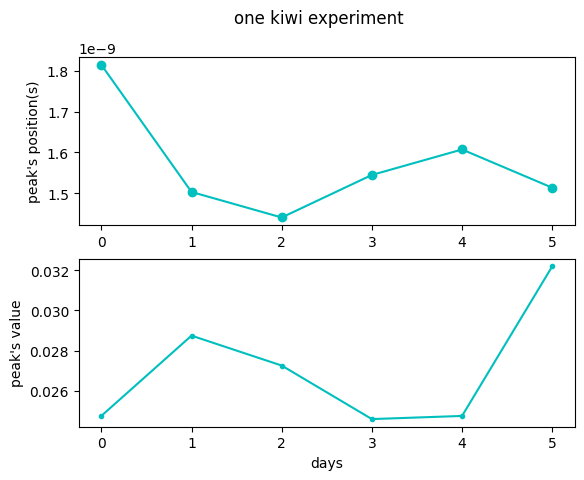

In [59]:
plt.figure(figsize=(5,6))
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('one kiwi experiment')

ax1.plot(peak_position_Y, 'o-')
ax1.set_ylabel('peak\'s position(s)')

ax2.plot(peak_Y, '.-')
ax2.set_xlabel('days')
ax2.set_ylabel('peak\'s value')

plt.show()
plt.show()

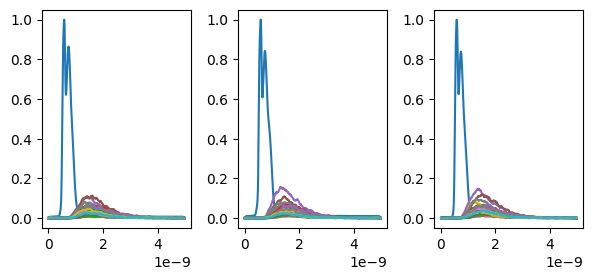

In [6]:
##########################################
fig = plt.figure(figsize = (8,8))
for i in range(AMOUNT_EXP):
    plt.subplot(3,4,i+1)
    plt.plot(TIME[i][0]*1e-9,H[i]/max(H[i]))
    for j in range(Y[i].shape[0]):
        plt.plot(TIME[i][j+1]*1e-9,Y[i][j,0:data_480multi9.shape[1]])
# plt.title.set_text(dict0[i][9:-4])
fig.tight_layout(pad=1.1)

plt.show()

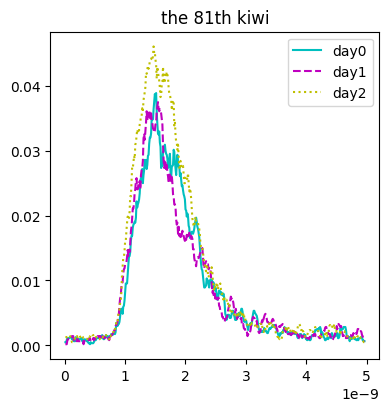

In [11]:
##########################################
fig = plt.figure(figsize = (4,4))
j = 80
line = []
line_irf = []
for i in range(AMOUNT_EXP):
    # linestyle_cycler = cycler('linestyle',['-','--',':','-.'])
    # plt.rc('axes', prop_cycle=linestyle_cycler)
    plt.rc('axes', prop_cycle=(cycler('color', ['c', 'm', 'y', 'k','r','g','b']) +
                           cycler('linestyle', ['-', '--', ':', '-.','-','--',':'])))
    line0, = plt.plot(TIME[i][j+1]*1e-9, Y[i][j,0:data_480multi9.shape[1]])
    # line1, = plt.plot(TIME[i][j+1]*1e-9, H[i]/max(H[i])*0.04,color='black')
    line.append(line0)
    # line_irf.append(line1)
fig.tight_layout(pad=1.1)
# line.extend(line_irf)
# plt.legend(line,['day0','day1','day2','day3','day5','day7','day8','day9','day11','day13','day15','IRF'])
plt.legend(line,['day0','day1','day2','day3','day5','day7','day8','day9','day11','day13','day15'])
name = "the "+str(j+1)+'th kiwi'
plt.title(label=name)


plt.show()

In [11]:
class calculate_miu_s1(object):
    
    def __init__(self, h, y, time_index,d):
        self.h = h
        self.y = y
        self.time = time_index
        self.d = d
        return None
    
    def transmittance(self, d, t, c, g, miu_a, miu_s):
        miu_s_prime = (1-g)*miu_s
        Z0 = 1/(miu_s_prime)
        D = 1/(3*(miu_a + miu_s_prime))
        h1 = math.pow(4*math.pi*D*c, -0.5)
        h2 = math.pow(t, -1.5)*math.exp(-miu_a*c*t)
        h3 = (d-Z0)*math.exp(-(math.pow(d-Z0, 2))/(4*D*c*t))
        h4 = (d+Z0)*math.exp(-(math.pow(d+Z0, 2))/(4*D*c*t))
        h5 = (3*d-Z0)*math.exp(-(math.pow(3*d-Z0, 2))/(4*D*c*t))
        h6 = (3*d+Z0)*math.exp(-(math.pow(3*d+Z0, 2))/(4*D*c*t))
    #     return d,Z0,D,c,t
        return h1*h2*(h3-h4+h5-h6)
    
    
    def error_cal(self, x):
        miu_a = x[0]
        #miu_a = 69
        miu_s = x[1]
         
        # k = 0.1
        # miu_a = 0.01e2
        g = 0.85
        # d = 0.38e-3
        d = self.d
        c = 3e8/1.3314
        T = int(480)
#         time = np.array(range(1,T, 1))
#         time = time*1e-8*0.010345058455114822
        time = self.time*1e-9
        # miu_s = miu_s*1e4
        intensity1 = np.zeros((T, ), dtype = float)
        for i in range(time.shape[0] ):

            intensity1[i] = calculate_miu_s1.transmittance(self, d, time[i], c, g, miu_a, miu_s)
        
        y2 = np.convolve(intensity1, self.h)
        self.intensity = intensity1
        self.y_convolved = y2
        y2 = y2/max(abs(y2))
        y3 = self.y/max(abs(self.y))
        
        return np.sum(abs(y2 - y3))
#         return time

    def get_convolved_signal(self):
        return self.y_convolved
        
    def get_x(self):
        return self.intensity

    




In [26]:
class call_cal(object):
    def __init__(self):
        return
    def call_cal(self,h,y,time_index,radius):
            # %%capture --no-display
            miu_s_get = np.zeros((y.shape[0],2))
            m1=[None]*y.shape[0]
            fun_value = np.zeros((y.shape[0],))
            bnds = ((0, None), (0, None))
            for i in range(y.shape[0]):
                d = radius[i]*1e-3
                m1[i] = calculate_miu_s1(h, y[i], time_index[i+1],d)
                try :
                    minu = minimize(m1[i].error_cal, x0 = [0.1e2,100e2], method  = 'Nelder-Mead', bounds = bnds, options={"xtol" : 1e-20, "disp":True})
                    miu_s_get[i], fun_value[i] = minu.x, minu.fun # Nelder-Mead
                except:
                    print("one error occured, on the "+str(i)+"th kiwi")
            return miu_s_get

    def call_(self,H,Y,TIME,R,AMOUNT_EXP):
        miu_as = []
        for i in range(AMOUNT_EXP):
            miu_s_get = self.call_cal(H[i],Y[i],TIME[i],R[i])
            miu_as.append(miu_s_get)
        return miu_as

In [27]:
call = call_cal()
miu_as = call.call_(H,Y,TIME,R,AMOUNT_EXP)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15292\420506800.py:14: OptimizeWarning: Unknown solver options: xtol
  minu = minimize(m1[i].error_cal, x0 = [0.1e2,100e2], method  = 'Nelder-Mead', bounds = bnds, options={"xtol" : 1e-20, "disp":True})
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15292\3771615487.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  Z0 = 1/(miu_s_prime)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15292\3771615487.py:16: RuntimeWarning: invalid value encountered in double_scalars
  h3 = (d-Z0)*math.exp(-(math.pow(d-Z0, 2))/(4*D*c*t))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15292\3771615487.py:17: RuntimeWarning: invalid value encountered in double_scalars
  h4 = (d+Z0)*math.exp(-(math.pow(d+Z0, 2))/(4*D*c*t))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15292\3771615487.py:18: RuntimeWarning: invalid value encountered in double_scalars
  h5 = (3*d-Z0)*math.exp(-(math.pow(3*d-Z0, 2))/(4*D*c*t))
C:\Users

one error occured, on0th kiwi
one error occured, on1th kiwi
one error occured, on2th kiwi
one error occured, on3th kiwi
one error occured, on4th kiwi
one error occured, on5th kiwi
one error occured, on6th kiwi
one error occured, on7th kiwi
one error occured, on8th kiwi
one error occured, on9th kiwi
one error occured, on10th kiwi
one error occured, on11th kiwi
one error occured, on12th kiwi
one error occured, on13th kiwi
one error occured, on14th kiwi
one error occured, on15th kiwi
one error occured, on16th kiwi
one error occured, on17th kiwi
one error occured, on18th kiwi
one error occured, on19th kiwi
one error occured, on20th kiwi
one error occured, on21th kiwi
one error occured, on22th kiwi
one error occured, on23th kiwi
one error occured, on24th kiwi
one error occured, on25th kiwi
one error occured, on26th kiwi
one error occured, on27th kiwi
one error occured, on28th kiwi
one error occured, on29th kiwi
one error occured, on30th kiwi
one error occured, on31th kiwi
one error occured,

In [22]:
avg_miu = [None]*AMOUNT_EXP
for i in range(AMOUNT_EXP):
    avg_miu[i] = np.sum(miu_as[i],axis=0)/Y[i].shape[0]

In [23]:
avg_miu

[array([   4.7154614 , 1618.87904118])]

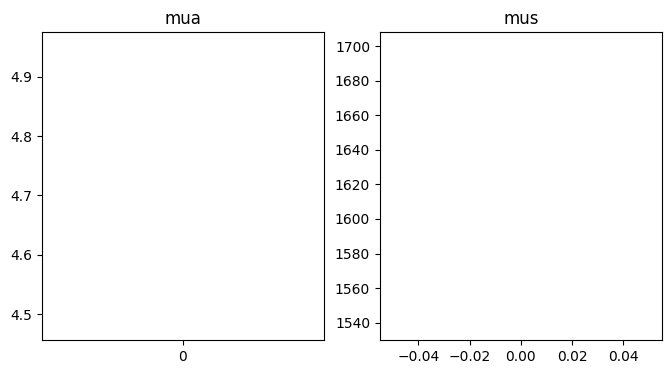

In [24]:
mua = []
for i in range(len(avg_miu)):
    mua.append(avg_miu[i][0])
mus = []
for i in range(len(avg_miu)):
    mus.append(avg_miu[i][1])
plt.figure(figsize = (8,4))
ax0=plt.subplot(1,2,1)
ax0.set_title('mua')
ax0.set_xticks([0,1,2,3,5,7])
ax0.plot(mua)
ax1=plt.subplot(1,2,2)
ax1.set_title('mus')
ax1.plot(mus)
plt.show()

In [29]:
# %%capture --no-display
miu = np.zeros((2,2))
miu = np.array([[83.21829252, 9789.38773514],[104.08146906,  9540.58548081]])
m2=[None]*2
d = np.array([1.3,3])*1e-3
yk0 = np.zeros((2,959))
for i in range(2):
    m2[i] = calculate_miu_s1(h[i], y[i], time_index[0],d[i])
    m2[i].error_cal([miu[i,0],miu[i,1]])
    yk0[i] = m2[i].get_convolved_signal()

6.232967532058431
[2.67471907 3.55824846]


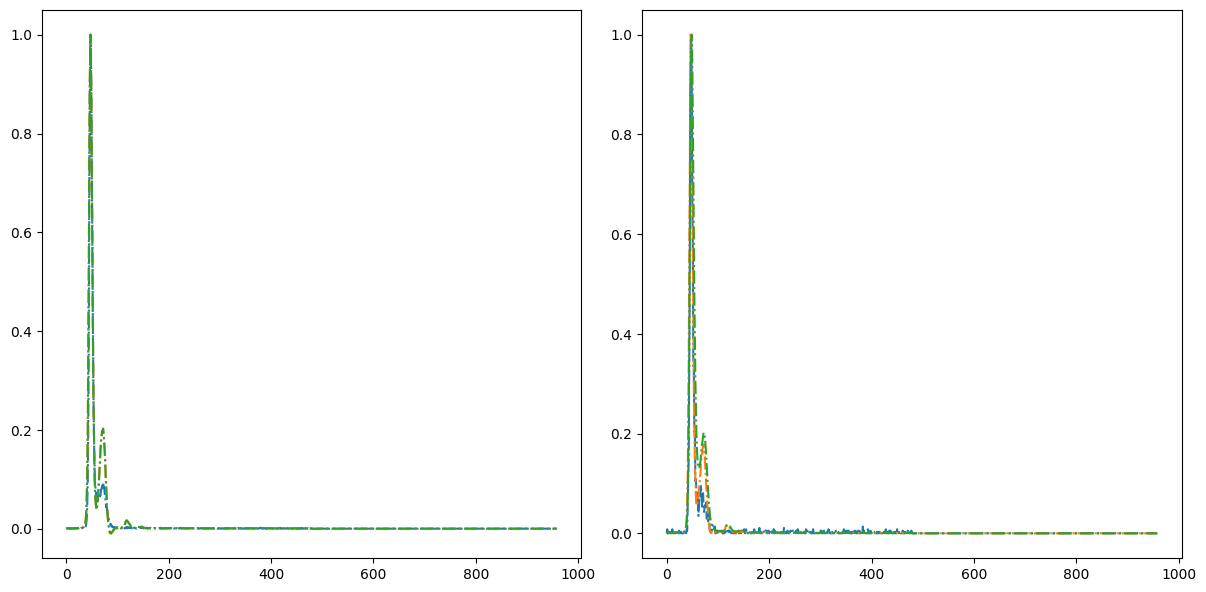

In [30]:
print(np.sum(abs(fun_value)))
print(fun_value)
plt.figure(figsize = (18,6))
yk1 = np.zeros((2,959))

for i in range (2):
    yk1[i] = m1[i].get_convolved_signal()

for i in range(2):
    plt.subplot(1,3,i+1)
    plt.plot(y[i,:]/max(abs(y[i,:])),'-.')
    plt.plot(yk1[i]/max(abs(yk1[i])),'-.')
    plt.plot(yk0[i]/max(abs(yk0[i])),'-.')
    
plt.tight_layout(pad=1.0)
plt.show()